<a href="https://colab.research.google.com/github/ArunKoundinya/DeepLearning/blob/main/posts/deep-learning-project-msis/AmazonReviews_Part6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Part 6

The main purpose of this file is to explore on pre-trained word-embeddings on the following models.

All models are tested on 10K dataset

## Table of Contents
- [1 - Packages](#1)
- [2 - Loading the Dataset](#2)
- [3 - Pre-Processing the Data](#3)
- [4 - Creating  for Loading Word Embeddings](#4)
- [5 - Model-1 Simple LSTM with Glove 6B 50d](#5)
- [6 - Model-2 LSTM 8 Units with Glove 6B 50d](#6)
- [7 - Model-3 LSTM 4 Units with Twitter 27B 50d](#7)
- [8 - Model-4 Bi-LSTM 4 Units with Twitter 27B 50d](#8)
- [9 - Model-5 Bi-LSTM 4 Units and FFN with Twitter 27B 50d](#9)
- [10 - Model-6 Bi-LSTM 4 Units with Globe 6B 300d](#10)
- [11 - Model-7 Bi-LSTM 4 Units with Twitter 27B 200d](#11)
- [12 - All Models Comparison](#12)

<a name='1'></a>
## 1 - Loading the Packages

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=6fe553c9d6418108cd50354ca70f208cedc3615d0f76de409ac5c8fab5e3cbb0
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

from sklearn.metrics import accuracy_score, classification_report

from pandarallel import pandarallel

<a name='2'></a>
## 2 - Loading the Data

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')

testdata = pd.read_csv('test_data_sample_complete.csv')
traindata = pd.read_csv('train_data_sample_complete.csv')


Mounted at /content/drive


In [ ]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<a name='3'></a>
## 3 - PreProcessing the Data

In [ ]:
train_data = traindata.sample(n=10000, random_state=42)
test_data = testdata.sample(n=1000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(10000, 100)
(500, 100)
(500, 100)


In [ ]:
vocab_size = len(tokenizer.word_index)

In [ ]:
word2idx = tokenizer.word_index

In [ ]:
list(word2idx.items())[1]


('not', 2)

<a name='4'></a>
## 4 - Functions for Loading Pre-Trained Embeddings

In [ ]:
def load_embeddings(glove_path):
    embedding_index = {}
    with open(glove_path, encoding="utf8") as glove_file:
        for line in glove_file:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embedding_index[word] = coefs
    return embedding_index

In [ ]:
def create_embedding_matrix(embedding_index, word2idx, vocab_size, embedding_dim):
    mat=np.zeros((vocab_size,embedding_dim))
    for key,value in word2idx.items():
      mat[value]=embedding_index.get(key)
    mat[np.isnan(mat)] = 0
    return mat

<a name='5'></a>
## 5 - Model-1 Simple LSTM with Glove 6B 50d

In [ ]:
glove_path = f"glove.6B/glove.6B.50d.txt"
embedding_index = load_embeddings(glove_path)

In [ ]:
embedding_matrix = create_embedding_matrix(embedding_index, word2idx, vocab_size, 50)
embedding_matrix[word2idx["book"]]

array([-0.0076543 ,  0.93456   , -0.73189002, -0.55162001,  0.76977003,
        0.35925001, -1.1365    , -1.16320002,  0.34213999,  0.29144999,
       -0.87110001,  0.91970003, -0.47069001, -0.22834   ,  1.4777    ,
       -0.81713998, -0.17466   , -0.51093   , -0.28354001,  0.23292001,
        0.71832001,  0.23413999,  0.49443001,  0.35483   ,  0.76889002,
       -1.43739998, -1.7457    , -0.28994   , -0.10156   , -0.36959001,
        2.55019999, -1.05809999, -0.049416  , -0.25523999, -0.63303   ,
        0.02671   , -0.18732999,  0.20206   , -0.26288   , -0.41418001,
        0.83473003, -0.14227   , -0.28125   ,  0.098155  , -0.17095999,
        0.52407998,  0.31851   , -0.089847  , -0.27223   , -0.0088736 ])

In [ ]:
model_lstm_bi_embed = Sequential()
model_lstm_bi_embed.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100,weights=[embedding_matrix], trainable=False))
model_lstm_bi_embed.add(LSTM(1, activation='tanh'))
model_lstm_bi_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           1956400   
                                                                 
 lstm (LSTM)                 (None, 1)                 208       
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 1956610 (7.46 MB)
Trainable params: 210 (840.00 Byte)
Non-trainable params: 1956400 (7.46 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed = model_lstm_bi_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 3ms/step - loss: 0.4752 - accuracy: 0.7900
Test Loss: 0.47515591979026794, Test Accuracy: 0.7900000214576721


In [ ]:
from plotnine import *

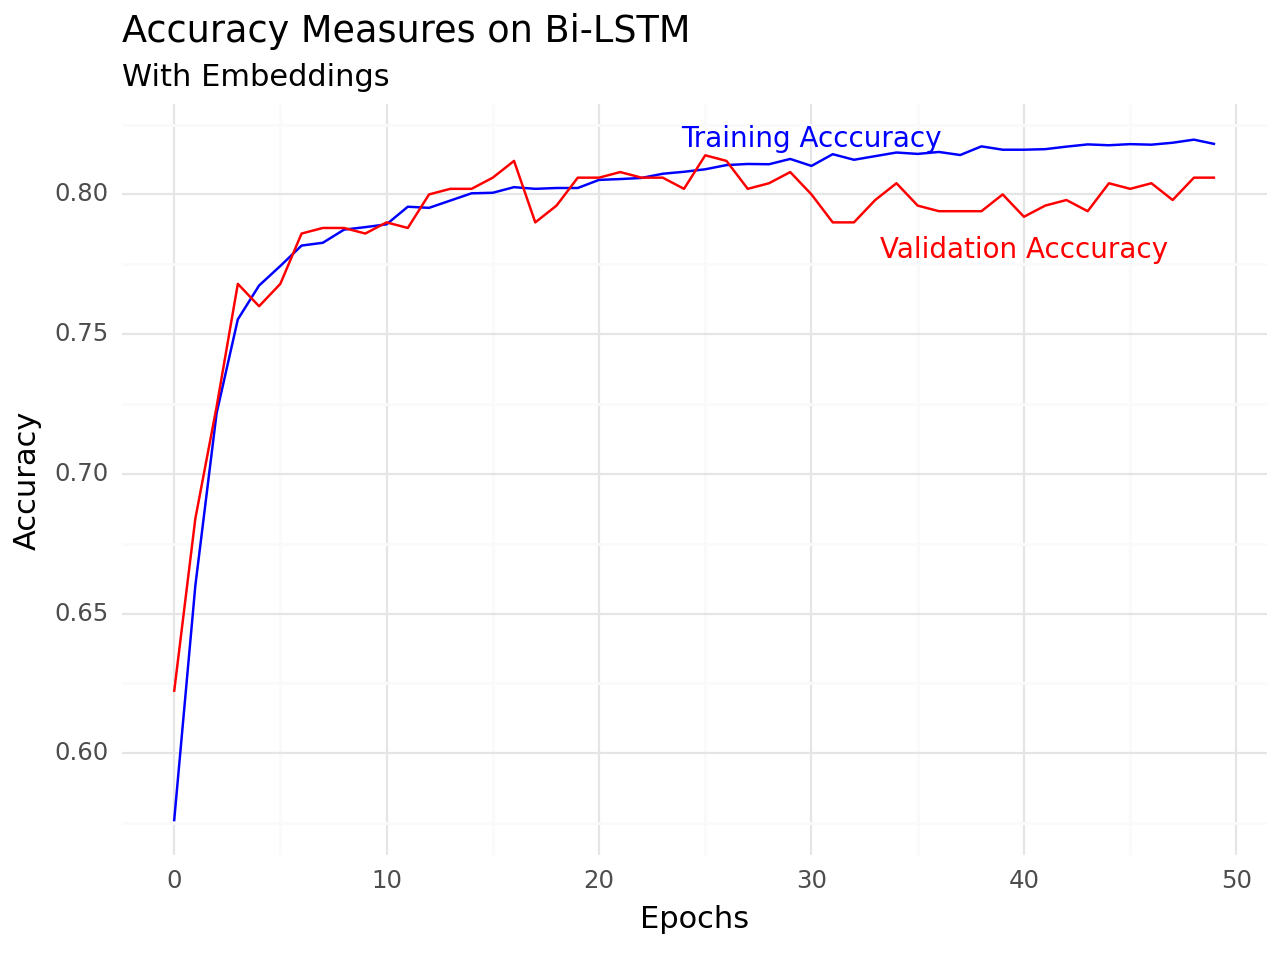

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.82,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.78,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='6'></a>
## 6 - Model-2 LSTM 8 Units with Glove 6B 50d

In [ ]:
model_lstm_bi_embed_1 = Sequential()
model_lstm_bi_embed_1.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100,weights=[embedding_matrix], trainable=False))
model_lstm_bi_embed_1.add(LSTM(8, activation='tanh'))
model_lstm_bi_embed_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           1956400   
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1888      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1958297 (7.47 MB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 1956400 (7.46 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_1 = model_lstm_bi_embed_1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_1.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 3ms/step - loss: 0.4377 - accuracy: 0.8360
Test Loss: 0.4376985430717468, Test Accuracy: 0.8360000252723694


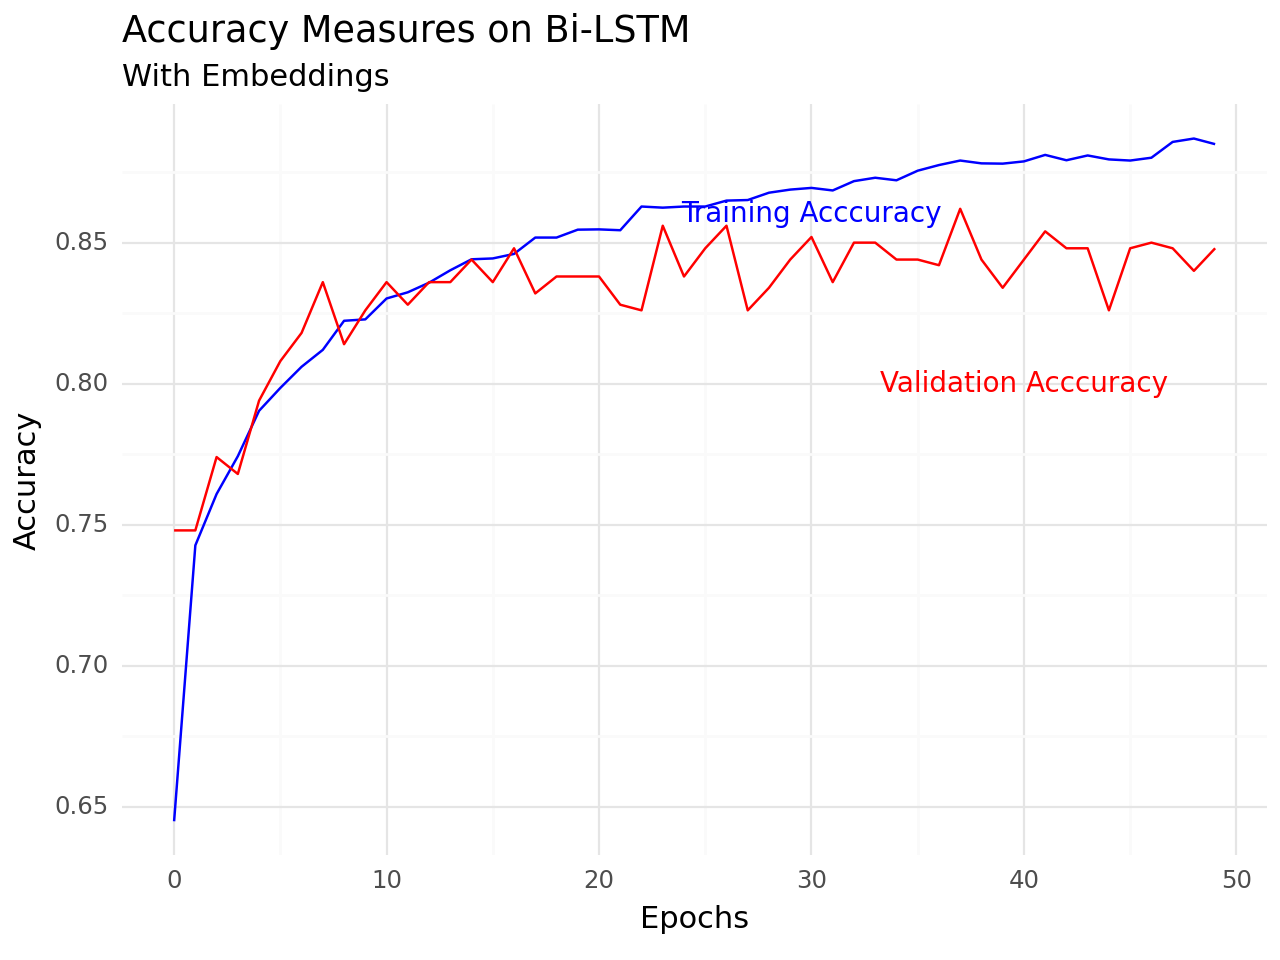

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_1.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_1.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.86,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.80,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='7'></a>
## 7 - Model-3 LSTM 4 Units with Twitter 27B 50d

In [ ]:
glove_path1 = f"glove.6B/glove.twitter.27B.50d.txt"
embedding_index_twitter = load_embeddings(glove_path1)

In [ ]:
embedding_matrix_twitter = create_embedding_matrix(embedding_index_twitter, word2idx, vocab_size, 50)
embedding_matrix_twitter[word2idx["book"]]

array([-1.15900002e-01,  3.01329996e-02, -2.13949997e-02,  9.47920009e-02,
        1.06019998e+00, -6.15769982e-01,  1.43900001e+00, -2.95729995e-01,
        1.72539994e-01, -1.84670001e-01,  1.73099995e-01, -1.11780003e-01,
       -4.13479996e+00,  2.44770005e-01, -6.08460009e-01, -1.13420002e-01,
        4.28909987e-01,  5.54899991e-01, -1.05920002e-01,  7.49319971e-01,
       -1.07729995e+00,  1.68329999e-02, -3.17149997e-01, -2.26789996e-01,
       -3.69700015e-01,  1.92179997e-02,  5.11020012e-02, -3.39399993e-01,
        9.18049991e-01,  1.39370002e-02,  6.78849995e-01, -2.76930004e-01,
       -2.80580014e-01, -3.39459985e-01,  9.13069991e-04, -1.27949998e-01,
        2.95179993e-01, -1.56729996e-01,  8.63489985e-01, -9.87519979e-01,
       -7.19649971e-01,  3.17539990e-01,  1.73409998e-01,  3.89070004e-01,
        9.12310004e-01,  1.72690004e-01, -2.32079998e-01, -5.95719993e-01,
       -1.06630003e+00, -3.66939992e-01])

In [ ]:
model_lstm_bi_embed_2 = Sequential()
model_lstm_bi_embed_2.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100,weights=[embedding_matrix_twitter], trainable=False))
model_lstm_bi_embed_2.add(LSTM(4, activation='tanh'))
model_lstm_bi_embed_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:

model_lstm_bi_embed_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           1956400   
                                                                 
 lstm_2 (LSTM)               (None, 4)                 880       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1957285 (7.47 MB)
Trainable params: 885 (3.46 KB)
Non-trainable params: 1956400 (7.46 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_2 = model_lstm_bi_embed_2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 3ms/step - loss: 0.3561 - accuracy: 0.8660
Test Loss: 0.35611701011657715, Test Accuracy: 0.8659999966621399


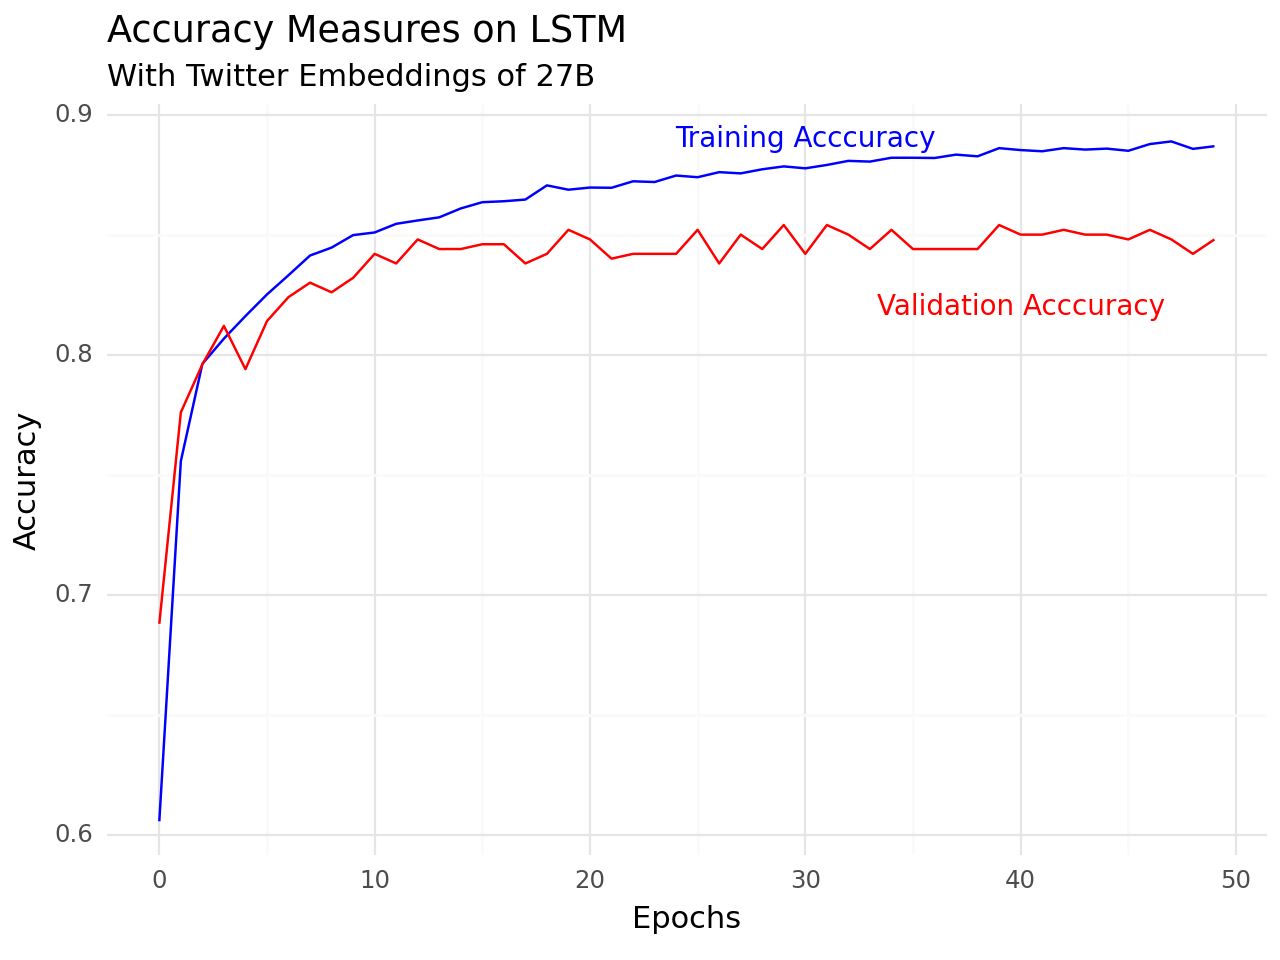

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_2.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_2.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on LSTM",
       subtitle = "With Twitter Embeddings of 27B") +
  annotate(
      "text",
      x = 30,
      y = 0.89,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.82,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='8'></a>
## 8 - Model-4 Bi-LSTM 4 Units with Twitter 27B 50d

In [ ]:
model_lstm_bi_embed_3 = Sequential()
model_lstm_bi_embed_3.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100,weights=[embedding_matrix_twitter], trainable=False))
model_lstm_bi_embed_3.add(Bidirectional(LSTM(4, activation='tanh')))
model_lstm_bi_embed_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           1956400   
                                                                 
 bidirectional (Bidirection  (None, 8)                 1760      
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1958169 (7.47 MB)
Trainable params: 1769 (6.91 KB)
Non-trainable params: 1956400 (7.46 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_3 = model_lstm_bi_embed_3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_3.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 0.3965 - accuracy: 0.8440
Test Loss: 0.3965199887752533, Test Accuracy: 0.843999981880188


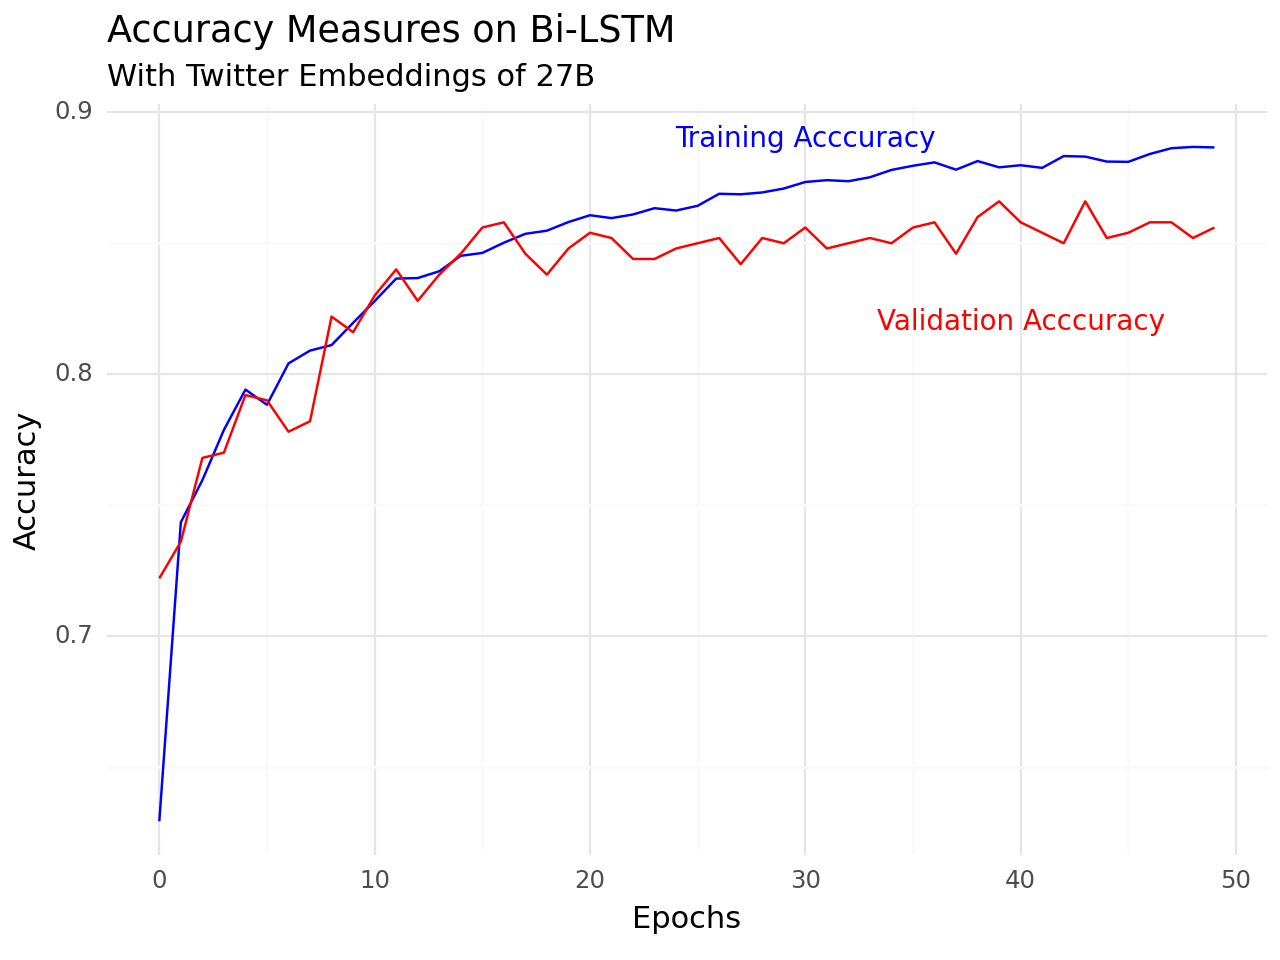

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_3.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_3.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Twitter Embeddings of 27B") +
  annotate(
      "text",
      x = 30,
      y = 0.89,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.82,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='9'></a>
## 9 - Model-5 Bi-LSTM 4 Units and FFN with Twitter 27B 50d

In [ ]:
model_lstm_bi_embed_4 = Sequential()
model_lstm_bi_embed_4.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=100,weights=[embedding_matrix_twitter], trainable=False))
model_lstm_bi_embed_4.add(Bidirectional(LSTM(4, activation='tanh')))
model_lstm_bi_embed_4.add(Dense(32, activation='relu'))
model_lstm_bi_embed_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 50)           1956400   
                                                                 
 bidirectional_1 (Bidirecti  (None, 8)                 1760      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1958481 (7.47 MB)
Trainable params: 2081 (8.13 KB)
Non-trainable params: 1956400 (7.46 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_4 = model_lstm_bi_embed_4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_4.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 0.3869 - accuracy: 0.8340
Test Loss: 0.3869432508945465, Test Accuracy: 0.8339999914169312


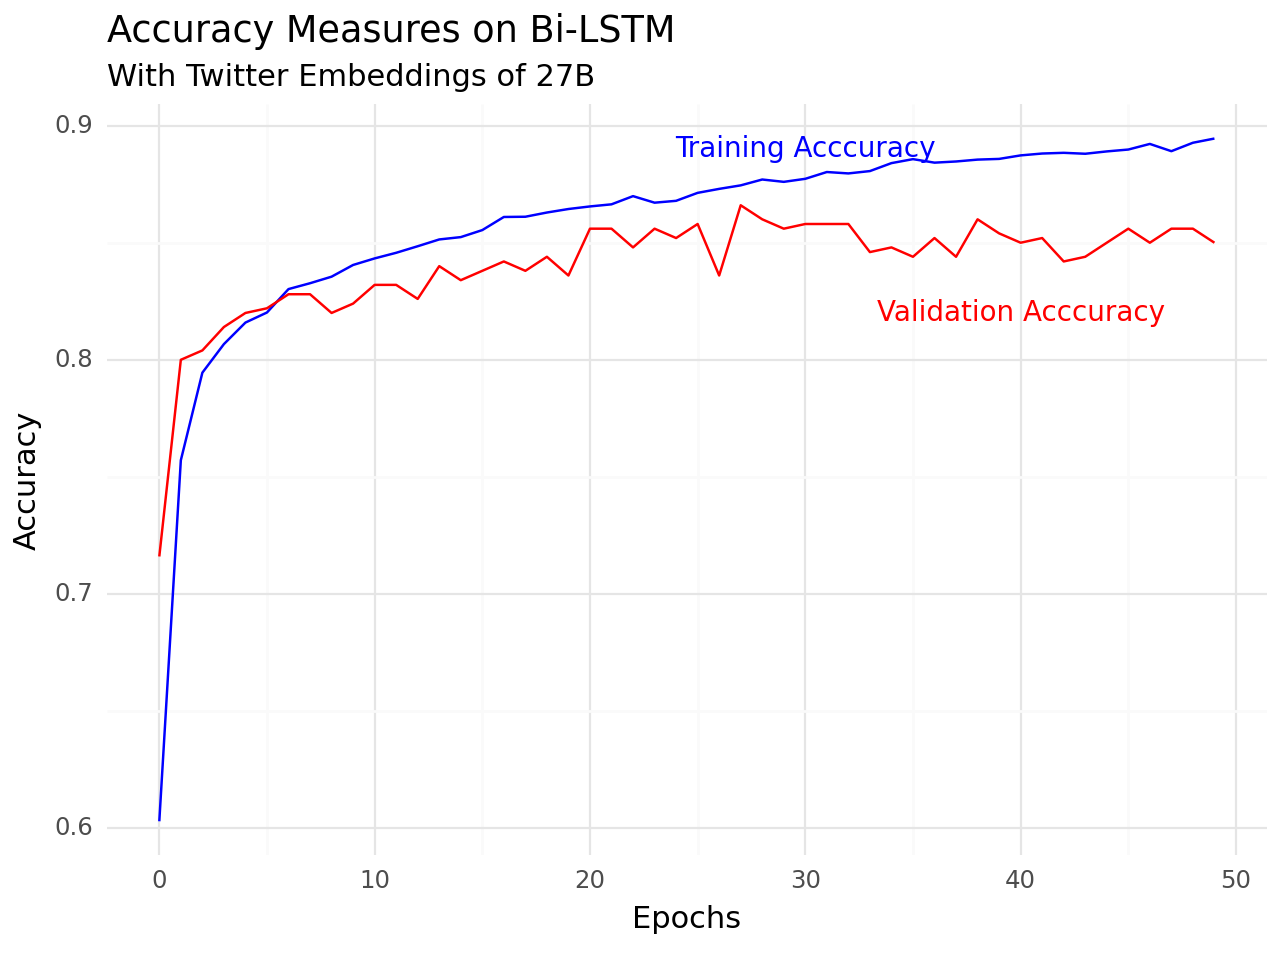

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_4.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_4.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Twitter Embeddings of 27B") +
  annotate(
      "text",
      x = 30,
      y = 0.89,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.82,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='10'></a>
## 10 - Model-6 Bi-LSTM 4 Units with Globe 6B 300d

In [ ]:
glove_path2 = f"glove.6B/glove.6B.300d.txt"
embedding_index_globe6B_300d = load_embeddings(glove_path2)

In [ ]:
embedding_matrix_glove_300d = create_embedding_matrix(embedding_index_globe6B_300d, word2idx, vocab_size, 300)
embedding_matrix_glove_300d[word2idx["book"]]

array([ 0.048733  , -0.055083  ,  0.14947   , -0.11269   ,  0.098791  ,
        0.54334003, -0.51204002,  0.27882001,  0.11497   , -1.33969998,
        0.41168001, -0.14742   ,  0.38694   , -0.0082414 , -0.03349   ,
       -0.057761  ,  0.022663  ,  0.1058    ,  0.010694  , -0.077614  ,
        0.05708   ,  0.54645997, -0.24267   ,  0.69788998,  0.31597   ,
        0.069026  ,  0.033726  , -0.10927   ,  0.19253001, -0.22226   ,
       -0.11307   ,  0.43937999, -0.60904998,  0.11049   , -1.40810001,
        0.37343001, -0.38587001, -0.31584999, -0.28639999, -0.33769   ,
        0.44442999, -0.14013   , -0.40928999,  0.59491998, -0.076971  ,
        0.085855  ,  0.11559   ,  0.38694   , -0.64595002,  0.14493001,
        0.43865001, -0.015834  ,  0.20396   ,  0.086829  , -0.061201  ,
        0.11602   , -0.62238002, -0.36195999,  0.065653  , -0.2465    ,
        0.12819999,  0.20121001,  0.57195997, -0.13376001,  0.13502   ,
       -0.33950999,  0.24845   , -0.29434001, -0.02516   ,  0.03

In [ ]:
model_lstm_bi_embed_5 = Sequential()
model_lstm_bi_embed_5.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=100,weights=[embedding_matrix_glove_300d], trainable=False))
model_lstm_bi_embed_5.add(Bidirectional(LSTM(4, activation='tanh')))
model_lstm_bi_embed_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          11738400  
                                                                 
 bidirectional_2 (Bidirecti  (None, 8)                 9760      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 11748169 (44.82 MB)
Trainable params: 9769 (38.16 KB)
Non-trainable params: 11738400 (44.78 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_5 = model_lstm_bi_embed_5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_5.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 0.3878 - accuracy: 0.8760
Test Loss: 0.38777685165405273, Test Accuracy: 0.8759999871253967


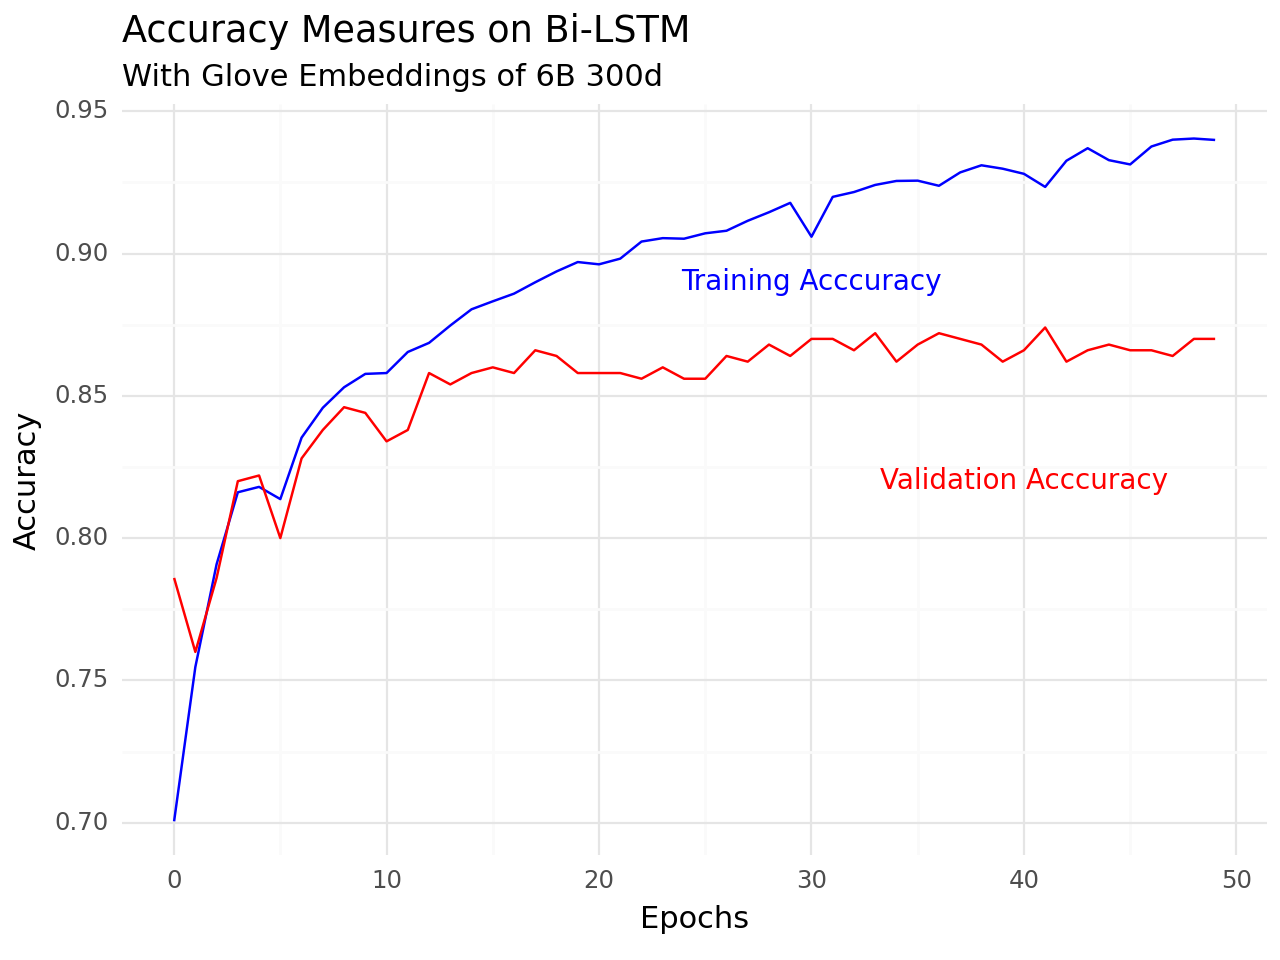

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_5.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_5.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Glove Embeddings of 6B 300d") +
  annotate(
      "text",
      x = 30,
      y = 0.89,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.82,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='11'></a>
## 11 - Model-7 Bi-LSTM 4 Units with Twitter 27B 200d

In [ ]:
glove_path3 = f"glove.6B/glove.twitter.27B.200d.txt"
embedding_index_Twitter_200d = load_embeddings(glove_path3)

In [ ]:
embedding_matrix_twitter_200d = create_embedding_matrix(embedding_index_Twitter_200d, word2idx, vocab_size, 200)
embedding_matrix_twitter_200d[word2idx["book"]]

array([-0.43551999,  0.16238999, -0.29269999, -0.29675001, -0.34759   ,
       -0.47275001,  0.8125    ,  0.25753999,  0.063817  , -0.39695999,
       -0.63590002,  0.27177   , -0.62805003, -0.56298   ,  0.18736   ,
       -0.2068    , -0.24707   ,  0.16885   ,  0.50615001,  0.031079  ,
        0.16841   , -0.87362999, -0.11618   ,  0.10592   , -0.35339999,
        0.65625   ,  0.070923  ,  0.098416  ,  0.47573   , -0.12987   ,
        0.22447   ,  0.69542003, -0.47979999, -0.16331001, -0.58661997,
        0.039876  ,  0.51730001, -0.081318  ,  0.33581001, -0.28227001,
        0.097423  ,  0.086391  , -0.012591  , -0.31064001,  0.049688  ,
        0.51059002, -0.25094   , -0.014923  ,  0.12813   , -0.20479999,
       -0.54636002, -0.055901  , -0.84912997, -0.23548   ,  0.17764001,
       -0.31343001,  0.34996   , -0.82489997, -0.17274   , -0.15154   ,
        0.33089   , -0.30372   ,  0.010554  , -0.078452  , -0.36133999,
        0.41997001, -0.15302999, -0.32323   ,  0.63178003, -0.09

In [ ]:
model_lstm_bi_embed_6 = Sequential()
model_lstm_bi_embed_6.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=100,weights=[embedding_matrix_twitter_200d], trainable=False))
model_lstm_bi_embed_6.add(Bidirectional(LSTM(4, activation='tanh')))
model_lstm_bi_embed_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:

model_lstm_bi_embed_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_6 = model_lstm_bi_embed_6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed_6.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 0.3825 - accuracy: 0.8540
Test Loss: 0.38252362608909607, Test Accuracy: 0.8539999723434448


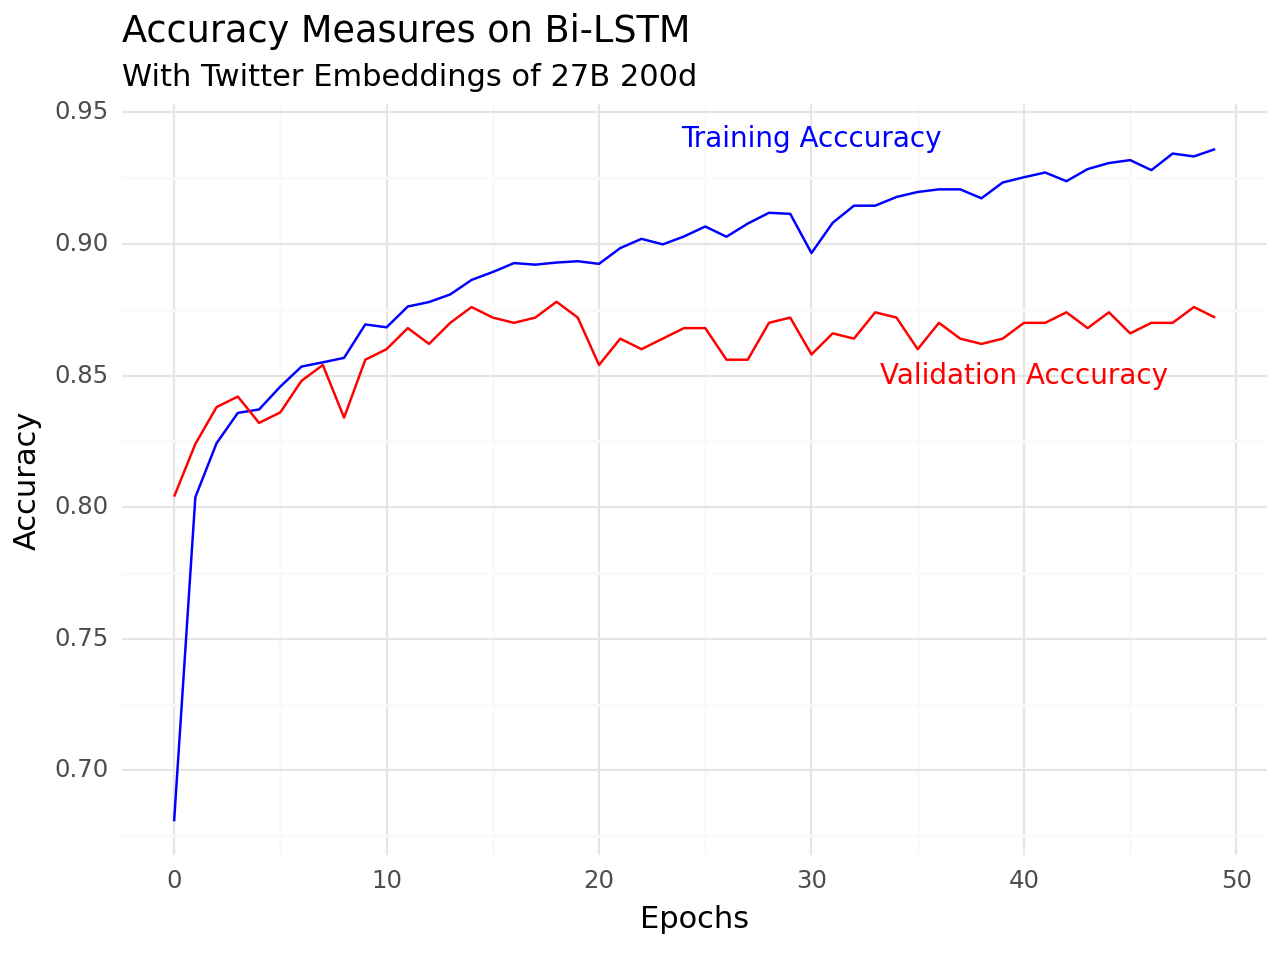

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed_6.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed_6.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Twitter Embeddings of 27B 200d") +
  annotate(
      "text",
      x = 30,
      y = 0.94,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.85,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='12'></a>
## 12 - All Models Comparison

In [ ]:
val_accuracy_df = pd.concat([
    pd.DataFrame(history_bilstm_embed.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_1.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_2.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_3.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_4.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_5.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed_6.history)['val_accuracy'],
], axis=1)

# Optional: Rename the columns for better identification
val_accuracy_df.columns = [
    'LSTM with Glove 6B',
    'LSTM with Glovemb 6B 8 units',
    'LSTM with Twitter 27 4 units',
    'Bi-LSTM with Twitter 27 4 units',
    'Bi-LSTM with Twitter 27 with FFN',
    'Bi-LSTM with Glove 6B 200d',
    'Bi-LSTM with Twitter 27B  300d',
]

# Display the concatenated DataFrame
print(val_accuracy_df)

    LSTM with Glove 6B  LSTM with Glovemb 6B 8 units  \
0                0.622                         0.748   
1                0.684                         0.748   
2                0.724                         0.774   
3                0.768                         0.768   
4                0.760                         0.794   
5                0.768                         0.808   
6                0.786                         0.818   
7                0.788                         0.836   
8                0.788                         0.814   
9                0.786                         0.826   
10               0.790                         0.836   
11               0.788                         0.828   
12               0.800                         0.836   
13               0.802                         0.836   
14               0.802                         0.844   
15               0.806                         0.836   
16               0.812                         0

/usr/local/lib/python3.10/dist-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_color_manual can return a maximum of 6 values. 7 were requested from it.
/usr/local/lib/python3.10/dist-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_color_manual can return a maximum of 6 values. 7 were requested from it.


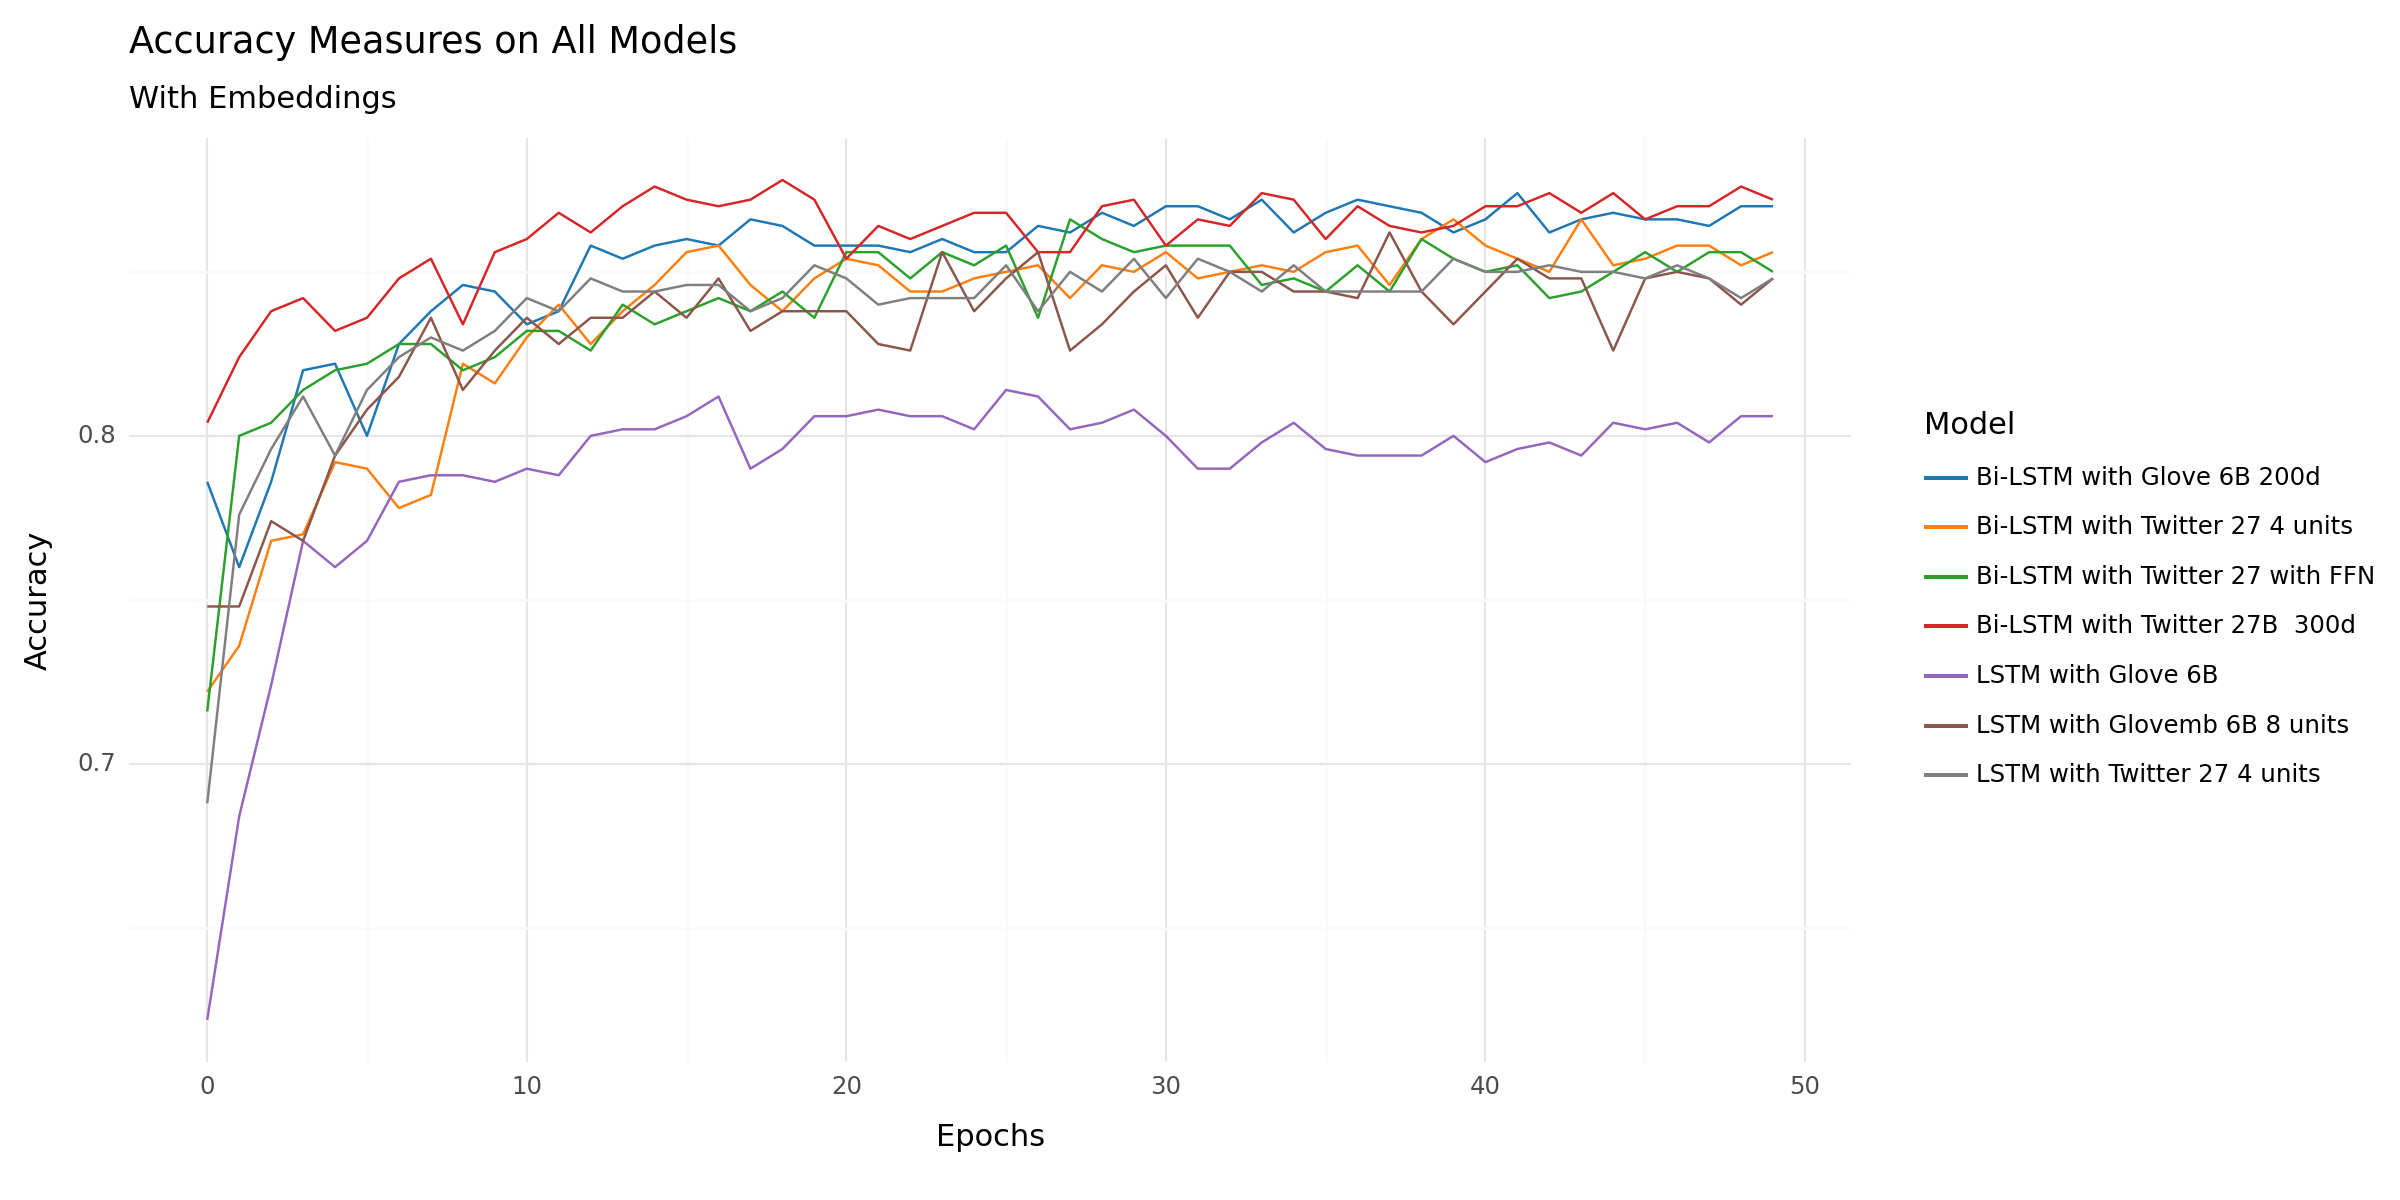

<Figure Size: (1200 x 600)>

In [ ]:
val_accuracy_df_long = val_accuracy_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Accuracy')

(
    ggplot(val_accuracy_df_long, aes(x='index', y='Accuracy', color='Model', label='Accuracy')) +
    geom_line() +
    scale_color_manual(values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]) +  # Set custom colors
    theme_minimal() +
    labs(x="Epochs", y="Accuracy", title="Accuracy Measures on All Models", subtitle="With Embeddings") +
    theme(figure_size=(12, 6))  # Increase figure size here
)





In [ ]:
val_accuracy_df_long.to_csv("val_accuracy_df_long_lstm_pretrainedembedding.csv", index=False)

In [ ]:
val_accuracy_df.to_csv("val_accuracy_df_lstm_pretrainedembedding.csv", index=False)

In [ ]:
train_data = traindata.sample(n=100000, random_state=42)
test_data = testdata.sample(n=10000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(100000, 100)
(5000, 100)
(5000, 100)


In [ ]:
len(tokenizer.word_index)

180362

In [ ]:
vocab_size = len(tokenizer.word_index)
word2idx = tokenizer.word_index
embedding_matrix_twitter_200d = create_embedding_matrix(embedding_index_Twitter_200d, word2idx, vocab_size, 200)
embedding_matrix_twitter_200d[word2idx["book"]]

array([-0.43551999,  0.16238999, -0.29269999, -0.29675001, -0.34759   ,
       -0.47275001,  0.8125    ,  0.25753999,  0.063817  , -0.39695999,
       -0.63590002,  0.27177   , -0.62805003, -0.56298   ,  0.18736   ,
       -0.2068    , -0.24707   ,  0.16885   ,  0.50615001,  0.031079  ,
        0.16841   , -0.87362999, -0.11618   ,  0.10592   , -0.35339999,
        0.65625   ,  0.070923  ,  0.098416  ,  0.47573   , -0.12987   ,
        0.22447   ,  0.69542003, -0.47979999, -0.16331001, -0.58661997,
        0.039876  ,  0.51730001, -0.081318  ,  0.33581001, -0.28227001,
        0.097423  ,  0.086391  , -0.012591  , -0.31064001,  0.049688  ,
        0.51059002, -0.25094   , -0.014923  ,  0.12813   , -0.20479999,
       -0.54636002, -0.055901  , -0.84912997, -0.23548   ,  0.17764001,
       -0.31343001,  0.34996   , -0.82489997, -0.17274   , -0.15154   ,
        0.33089   , -0.30372   ,  0.010554  , -0.078452  , -0.36133999,
        0.41997001, -0.15302999, -0.32323   ,  0.63178003, -0.09

In [ ]:
model_lstm_bi_embed_6 = Sequential()
model_lstm_bi_embed_6.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=100,weights=[embedding_matrix_twitter_200d], trainable=False))
model_lstm_bi_embed_6.add(Bidirectional(LSTM(4, activation='tanh')))
model_lstm_bi_embed_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed_6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 200)          36072400  
                                                                 
 bidirectional_5 (Bidirecti  (None, 8)                 6560      
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 36078969 (137.63 MB)
Trainable params: 6569 (25.66 KB)
Non-trainable params: 36072400 (137.61 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed_6 = model_lstm_bi_embed_6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=1)

loss, accuracy = model_lstm_bi_embed_6.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/50
1563/1563 [==============================] - 18s 10ms/step - loss: 0.3889 - accuracy: 0.8327 - val_loss: 0.3347 - val_accuracy: 0.8568
Epoch 2/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2973 - accuracy: 0.8764 - val_loss: 0.3010 - val_accuracy: 0.8696
Epoch 3/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2752 - accuracy: 0.8867 - val_loss: 0.2999 - val_accuracy: 0.8690
Epoch 4/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2636 - accuracy: 0.8919 - val_loss: 0.2880 - val_accuracy: 0.8788
Epoch 5/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2565 - accuracy: 0.8952 - val_loss: 0.2783 - val_accuracy: 0.8838
Epoch 6/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2499 - accuracy: 0.8984 - val_loss: 0.2768 - val_accuracy: 0.8856
Epoch 7/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2463 - accuracy: 0.9010 - val_loss: 0.2745 - val_a

In [ ]:
import pickle

with open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/model_lstm_bi_embed_pretrained.pkl', 'wb') as f:
  pickle.dump(model_lstm_bi_embed_6, f)


streamlit

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')


Mounted at /content/drive


In [ ]:
%%writefile app.py
import numpy as np
import pandas as pd
import streamlit as st
import pickle
import warnings
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

model_rfm = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/best_model_traditional.pkl', 'rb'))
model_bistm = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/model_lstm_bi_embed.pkl', 'rb'))
model_bistm_pretrained = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/model_lstm_bi_embed_pretrained.pkl', 'rb'))
vocab_dict = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/vocab_dict.pkl', 'rb'))

cols= ['review_title','review_text']


def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text into words
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    text = ' '.join(words)
    return text

stop_words = set(stopwords.words('english')) - { 'not', 'no', 'couldn', "couldn't", "wouldn't", "shouldn't", "isn't",
                                                "aren't", "wasn't", "weren't", "don't", "doesn't", "hadn't", "hasn't",
                                                 "won't", "can't", "mightn't","needn't","nor","shouldn","should've","should",
                                                 "weren","wouldn","mustn't","mustn","didn't","didn","doesn","did","does","hadn",
                                                 "hasn","haven't","haven","needn","shan't"}

def process_sentence(sentence):
  list1 = []
  for word in sentence.split():
    if word in vocab_dict:
      list1.append(vocab_dict[word])
    else:
      list1.append(vocab_dict["<UNK>"])
  return list1

def format_examples(data1, vocab_dict, maxlen):
  sequences_data=data1['review_combined_lemma'].apply(process_sentence).tolist()
  padded_sequences_data = pad_sequences(sequences_data, maxlen=maxlen)
  return padded_sequences_data

def main():
    st.title("Sentiment Predictor")
    html_temp = """
    <div style="background:#025246 ;padding:10px">
    <h2 style="color:white;text-align:center;">Sentiment Prediction App </h2>
    </div>
    """
    st.markdown(html_temp, unsafe_allow_html = True)

    model_selected = st.radio('Pick Model:', ['Random Forest','Bi-LSTM with Embedded Layer','Bi-LSTM with Pre-Trained Embedded Layer'])

    review_title = st.text_area('REVIEW TITLE')
    review_text = st.text_area('REVIEW TEXT')
    features = [[review_title,review_text]]

    data = {'review_title': str(review_title),'review_text': str(review_text)}

    df=pd.DataFrame([list(data.values())], columns=cols)

    df['review_combined'] = df['review_title'] + " " + df['review_text']
    df['review_combined_lemma'] = df['review_combined'].apply(preprocess)

    if st.button("Predict"):
        #print(data)

        if model_selected == 'Random Forest':
          prediction = model_rfm.predict(df['review_combined_lemma'].values)
        elif model_selected == "Bi-LSTM with Embedded Layer":
          X_review_combined_lemma = format_examples(df, vocab_dict, 100)
          prediction = model_bistm.predict(X_review_combined_lemma).astype(float)
        else :
          X_review_combined_lemma = format_examples(df, vocab_dict, 100)
          prediction = model_bistm_pretrained.predict(X_review_combined_lemma).astype(float)

        if float(prediction) > 0.5:
            st.success('Postive!!')
        else:
            st.success('Negative!!')

if __name__=='__main__':
    main()

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

34.143.190.49


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.190.49:8501

npx: installed 22 in 2.247s
your url is: https://brave-turkeys-move.loca.lt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-04-27 21:23:18.575918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 21:23:18.575964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 21:23: